In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

# Quantum Trajectories Simulation of Multilevel Driven-Dissipative system: Different Unravelings of the Master Equation

## Model and Motivation 

### General Concepts

The goal of this notebook is to use a simple model of a driven-dissipative system with multiple jump operators to understand how the quantum trajectories formalism applies to this case. In particular, multiple jump operators allows for the idea of different "unravelings" of the master equation to occur - wherein we can probe the system using differen sets of POVMs or Kraus operators. In this case, we will consider Coherent Population Trapping (CPT), i.e. population of a dark state, in a two-level system with 3-fold Zeeman degeneracy. The general master equation for a system with multiple Linblad jump operators $\hat{L}_{\mu}$ is given by 
$$\frac{\partial \hat{\rho}}{\partial t} = -\frac{i}{\hbar}\left[H_{eff},\hat{\rho}\right]' + \sum_{\mu = 1}^{M}\hat{L}_\mu\hat{\rho}\hat{L}_{\mu}^\dagger$$ with $\hat{H}_{eff} = \hat{H} - \frac{i\hbar}{2}\sum_{\mu}\hat{L}_{\mu}^\dagger\hat{L}_{\mu}$ and the $\left[~,~\right]'$ means we take the Hermitian conjugate of the non-Hermitian Hamiltonian $H_{eff}$ in the commutator. The probability for each possible jump is given by $\delta p_{\mu} = \langle\psi|\hat{L}_{\mu}^\dagger\hat{L}_{\mu}|\psi\rangle\delta t$ with the total jump probability $\delta p = \sum_{\mu}\delta p_{\mu}$. 

The MCWF simulation runs like this: 
1. Pick a random number $0<\epsilon<1$.
2. Evolve the wavefunction forward in time as $|\psi(\delta t)\rangle = e^{-i\hat{H}_{eff}\delta t/\hbar}|\psi(0)\rangle$. When $|\psi(\tau)|^2 = \langle\psi(0)|e^{\frac{i}{\hbar}(\hat{H}_{eff}^\dagger-\hat{H}_{eff})\tau}|\psi(0)\rangle <\epsilon $, then perform a jump. This is statistically equivalent to saying that when $\delta p >\epsilon \rightarrow$ jump.
3. Choose *which* jump with another random number $0<\eta<1$. The $\mu$-th jump is taken for $\delta p_{\mu}/\delta p > \eta$. 
4. Renormalize, then again look at the decaying norm and jump agaion when the new WF and $\epsilon$ are at $|\psi(\tau_2)|^2 = \langle\psi(\tau)|e^{\frac{i}{\hbar}(\hat{H}_{eff}^\dagger-\hat{H}_{eff})\tau_2}|\psi(\tau)\rangle <\tilde{\epsilon}$ Repeat for times $\tau$ as long out as you want. 
5. Finally, at the end, $|\psi(t)\rangle$ needs to be renormalized at each intermediate time where a jump was not taken. 

### Specific Example: Spontaneous Emission w/ Zeeman Degeneracy

Consider an atom with ground and excited state manifolds $J_{g,e}$ with total angular momentum $F_{e,g} = 1$ and projection along some quantization axis z $m_F = 0,\pm 1$. States $|F_{e},m_{F_e}\rangle$ and $|F_{g},m_{F_g}\rangle$ are connected by electric dipole transitions with $m_{e}-m_{g} = q = 0,\pm 1$ driven by photons of polarization $\vec{e}_q$. The jump operators $\hat{L}_q$ then correspond to emission of a photon with $q = 0$ ($\pi$ transition) or $q = \pm 1$ ($\sigma_{\pm}$ transitions). The jump operators are then given by 
$$\hat{L}_q = \sqrt{\Gamma}\sum_{m_e,m_g}\langle F_{e},m_e|F_{g},m_g,q\rangle |F_g,m_g\rangle\langle F_e,m_e| = \sum_{m_e,m_g}\sqrt{\Gamma_q}~|F_g,m_g\rangle\langle F_e,m_e|$$ where $\Gamma_q = \Gamma|\langle F_e,m_e|F_g,m_g,1_q\rangle| = \Gamma C^{J_e,J_g}_{m_e,m_g,1_q}$ is the spontaneous emission rate from $|F_e,m_e\rangle \rightarrow |F_g,m_g\rangle$ by emitting a photon of polarization $q$, determined by the Clebsch-Gordon coefficents $C^{J_e,J_g}_{m_e,m_g,1_q}$.

## Unraveling 1: Quantization Along $\vec{k} = \vec{z}$

First we suppose that the atom is driven by linearly polarized light with the quantization axis parallel to the momentum axis of the incoming light, $\vec{k}~||~\vec{z}$ and polarization along $\vec{e}_y$. Thus, there is only $\vec{e}_{\pm 1}$ ($\sigma_{\pm}$) light, not $\vec{e}_{0}$ ($\pi$) light, because a transverse wave cannot induce transitions along its direction of propagation. The polarization momentum is related to the axes we have chosen by $\vec{e}_0 = \vec{e}_z$ and $\vec{e}_{\pm} = \mp(\vec{e}_x\pm i\vec{e}_y)/\sqrt{2}$.

The Hamiltonian for the coherent drive is given by 
$$\hat{H} = -\Delta_{-1}|g,-1\rangle\langle g,-1|-(\Delta_{-1}-\Delta_{1})|g,1\rangle\langle g,1|-\frac{\hbar\Omega}{2}\left(\hat{D}_y+\hat{D}_y^\dagger\right)$$
Where $\Delta_{1,-1}$ are the detunings between the $|e,0\rangle$ state and $|g,\pm 1\rangle$ states, which we will set to zero, and $\Omega$ is the rabi freqeuncy. The raising and lowering operators $\hat{D}_y^{(\dagger)}$ are given by $$\hat{D}^\dagger_y = \sum_{q = 0,\pm 1}\hat{D}^\dagger_q(\vec{e}_q\cdot\vec{e}_y)$$
$$\hat{D}_y = \sum_{q = 0,\pm 1}\hat{D}_q(\vec{e}_q^*\cdot\vec{e}_y)$$

We want to study the evolutioon of the population of the dark state using $m_z$ as our quantization axis, given by $$|\psi_D\rangle = \frac{|F_g,m_z=-1\rangle + |F_g,m_z=+1\rangle}{\sqrt{2}},$$ which is uncoupled from the laser due to destructive interference.

In [243]:
#Introduce Parameters, set hbar = 1
delta1 = 0; #detuning
delta2 = 0;
Gamma=1;
Omega = 3;#units of Gamma 
dt = 0.005; #time step

In [244]:
tarray = np.arange(0,10,dt)

In [245]:
#Jump Operators
D0=np.zeros((6,6),dtype=np.complex)
D0[0,3]=1/np.sqrt(2)
D0[2,5]=-1/np.sqrt(2)

D1=np.zeros((6,6),dtype=np.complex)
D1[1,3]=-1/np.sqrt(2)
D1[2,4]=-1/np.sqrt(2)

Dm1=np.zeros((6,6),dtype=np.complex)
Dm1[0,4]=1/np.sqrt(2)
Dm1[1,5]=1/np.sqrt(2)

Jump0=np.dot(np.conj(D0).T,D0)
Jump1=np.dot(np.conj(D1).T,D1)
Jumpm1=np.dot(np.conj(Dm1).T,Dm1)

In [246]:
Dy = 1j/np.sqrt(2)*(Dm1+D1)

In [247]:
H=-Omega/2*(np.conj(Dy).T+Dy)

In [248]:
Heff=H-1j*Gamma/2*(np.dot(np.conj(D0).T,D0)+np.dot(np.conj(D1).T,D1)+np.dot(np.conj(Dm1).T,Dm1))

In [249]:
psiDark=np.zeros((1,6),dtype=np.complex).T
psiDark[0,0]=1
psiDark[2,0]=1
norm=np.linalg.norm(psiDark)#normalize
psiDark=psiDark/norm

In [250]:
psiinit=np.zeros((1,6),dtype=np.complex).T
psiinit[2,0]=1
norm=np.linalg.norm(psiinit)#normalize
psiinit=psiinit/norm

In [251]:
psiup=np.zeros((1,6),dtype=np.complex).T
psiup[4,0]=1
norm=np.linalg.norm(psiup)#normalize
psiup=psiup/norm

In [308]:
epsilon = np.random.rand(1)[0];

In [309]:
epsilon

0.29657438105794121

In [310]:
wf=psiinit;
dp=np.linalg.norm(wf)**2

In [311]:
wfarray=[];
dparray=[];

In [312]:
#Step 2: if decaying norm is less than epsilon, we jump and then renormalize. How we pick which jump to do?
#projection onto excited state manifold for current WF
pjump=np.absolute(np.dot(np.conj(wftest).T,np.dot(Jump0+Jump1+Jumpm1,wftest))[0,0])*dt
#individual jump probabilities
pjump0=np.absolute(np.dot(np.conj(wftest).T,np.dot(Jump0,wftest))[0,0])*dt
pjump1=np.absolute(np.dot(np.conj(wftest).T,np.dot(Jump1,wftest))[0,0])*dt
pjumpm1=np.absolute(np.dot(np.conj(wftest).T,np.dot(Jumpm1,wftest))[0,0])*dt

In [313]:
for el in tarray:
    #Step 1: look at the decaying norm of the WF. When it is less than epsilon, jump. DO NOT reassign wf until this happens
    wftemp=np.dot(linalg.expm(-1j*Heff*el),wf)
    norm=np.linalg.norm(wftemp)
    if norm**2<epsilon:
        epsilon = np.random.rand(1)[0];#first assign a new epsilon
        #Step 2: if decaying norm is less than epsilon, we jump and then renormalize. How we pick which jump to do?
        #projection onto excited state manifold for current WF
        pjump=np.absolute(np.dot(np.conj(wftemp).T,np.dot(Jump0+Jump1+Jumpm1,wftemp))[0,0])*dt
        #individual jump probabilities
        pjump0=np.absolute(np.dot(np.conj(wftemp).T,np.dot(Jump0,wftemp))[0,0])*dt
        pjump1=np.absolute(np.dot(np.conj(wftemp).T,np.dot(Jump1,wftemp))[0,0])*dt
        pjumpm1=np.absolute(np.dot(np.conj(wftemp).T,np.dot(Jumpm1,wftemp))[0,0])*dt
        #ratio of each jump probability to the total jump probability
        pm1r=pjumpm1/pjump
        p1r=pjump1/pjump
        p0r=pjump0/pjump
        #print(pm1r,p1r,p0r)
        #poor man's QM jumps for equal probability options. CHECK ON THIS!!
        eta = np.random.rand(1)[0];#generate a new random number to determine which qm jump to take
        if eta<p1r:
            wftemp=np.dot(D1,wftemp)
            norm=np.linalg.norm(wftemp)
            wftemp=wftemp/norm
            norm=np.linalg.norm(wftemp)
        else:
            wftemp=np.dot(Dm1,wftemp)
            norm=np.linalg.norm(wftemp)
            wftemp=wftemp/norm
            norm=np.linalg.norm(wftemp)
    wfarray.append(wftemp)
    dparray.append(norm)
    #wf=wftemp

In [313]:
for el in tarray:
    #Step 1: look at the decaying norm of the WF. When it is less than epsilon, jump.
    wftemp=np.dot(linalg.expm(-1j*Heff*el),wf)
    norm=np.linalg.norm(wftemp)
    if norm**2<epsilon:
        epsilon = np.random.rand(1)[0];#first assign a new epsilon
        #Step 2: if decaying norm is less than epsilon, we jump and then renormalize. How we pick which jump to do?
        #projection onto excited state manifold for current WF
        pjump=np.absolute(np.dot(np.conj(wftemp).T,np.dot(Jump0+Jump1+Jumpm1,wftemp))[0,0])*dt
        #individual jump probabilities
        pjump0=np.absolute(np.dot(np.conj(wftemp).T,np.dot(Jump0,wftemp))[0,0])*dt
        pjump1=np.absolute(np.dot(np.conj(wftemp).T,np.dot(Jump1,wftemp))[0,0])*dt
        pjumpm1=np.absolute(np.dot(np.conj(wftemp).T,np.dot(Jumpm1,wftemp))[0,0])*dt
        #ratio of each jump probability to the total jump probability
        pm1r=pjumpm1/pjump
        p1r=pjump1/pjump
        p0r=pjump0/pjump
        #print(pm1r,p1r,p0r)
        #poor man's QM jumps for equal probability options. CHECK ON THIS!!
        eta = np.random.rand(1)[0];#generate a new random number to determine which qm jump to take
        if eta<p1r:
            wftemp=np.dot(D1,wftemp)
            norm=np.linalg.norm(wftemp)
            wftemp=wftemp/norm
            norm=np.linalg.norm(wftemp)
        else:
            wftemp=np.dot(Dm1,wftemp)
            norm=np.linalg.norm(wftemp)
            wftemp=wftemp/norm
            norm=np.linalg.norm(wftemp)
    wfarray.append(wftemp)
    dparray.append(norm)
    wf=wftemp

Herein lies the issue, if each possible jump is equally probably, how to we choose which one to do? Based on some other random number?

In [314]:
#Go back and normalize all the wafefunctions
for i in range(0,len(wfarray)):
    norm=np.linalg.norm(wfarray[i])
    wfarray[i]=wfarray[i]/norm

In [315]:
pD=np.zeros(len(wfarray));#Dark state overlap
pE=np.zeros(len(wfarray));#Excited State mz = 0 overlap
wfa=np.array(wfarray);
for i in range(0,len(wfarray)):
    pD[i]=np.absolute(np.dot(psiDark.T,wfarray[i]))[0,0]**2
    pE[i]=np.absolute(np.dot(psiup.T,wfarray[i]))[0,0]**2

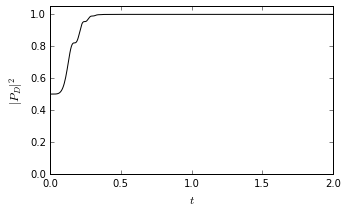

In [316]:
fig = plt.figure(figsize = (1.5*3.38,1.5*2))  
ax = fig.add_subplot(111)
ax.plot(list(tarray[0:len(pD)]),pD,color='k',label='Jumps')
#ax.plot(list(tarray[0:len(pD)]),pE,color='b',label='Jumps')
ax.set_xlim([0,2])
ax.set_ylim([0,1.05])
ax.set_xlabel(r'$t$',fontsize=12)
ax.set_ylabel(r'$|P_D|^2$',fontsize=12)
#ax.legend(loc='lower right',ncol=2,title=r'',fontsize=10)
plt.show()